In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import ast
import seaborn as sns
import numpy as np
import scipy
from sklearn import decomposition
from sklearn.cluster import KMeans, DBSCAN
from helpers import *

In [2]:
# conda install -c plotly plotly=5.11.0
# conda install -c conda-forge jupyterlab-plotly-extension
import plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#pio.renderers.default = 'jupyterlab'
#plotly.offline.init_notebook_mode(connected=True)

## Clustering

Let's import the data set that we are going to use for the analysis in this notebook.

In [3]:
df_movie = pd.read_csv("Expanded_data/big_data_final.tsv",sep='\t',low_memory=False)

In [4]:
columns_character = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date', 'Character name', 'Actor date of birth',
                     'Actor gender', 'Actor height (in meters)', 'Actor ethnicity (Freebase ID)', 'Actor name',
                     'Actor age at movie release', 'Freebase character/actor map ID', 'Freebase character ID',
                     'Freebase actor ID']

df_character = pd.read_csv("MovieSummaries/character.metadata.tsv",sep='\t',names=columns_character)

### 1) Preprocessing

As we want to do clustering we have to create a big matrix with many features to reduce. 

In [5]:
data = df_movie[['Freebase movie ID', 'Movie genres names', 'averageRating', 'inflation corrected budget', 'inflation corrected revenue', 'prod_country']].dropna()

First, we incorporated the movie genres as dummy variable :

In [6]:
movie_genres = [ast.literal_eval(movie_genre) for movie_genre in data['Movie genres names']]
data, genre_names = incorporate_genre_dummies(data)
data = data.drop(columns = ['Movie genres names'])

In [7]:
data.iloc[:,5:27].sum() 

Action         1141
Adventure       726
Animation        29
Biography       251
Comedy         1563
Crime           862
Documentary      27
Drama          2135
Family          219
Fantasy         363
History         136
Horror          440
Music           143
Musical          52
Mystery         410
News              2
Romance         779
SciFi           353
Sport           105
Thriller        717
War              86
Western          40
dtype: int64

We decided to drop the News feature as only very few movies are in this categorie :

In [8]:
data = data.drop(columns = ['News'])

There are also music and musical genres, we can join these two features in one :

In [9]:
data['Music'] = np.logical_or(data['Music'], data['Musical']).sum()
data = data.drop(columns = ['Musical'])

Then, we can also incorporate the production country as dummy variables, but we take into account only the countries that have 10 movies and more :

In [10]:
cutoff_country_list = (data.groupby('prod_country').count()['Freebase movie ID'] < 10) 
cutoff_country_list = list(cutoff_country_list[cutoff_country_list].index)

In [11]:
data = pd.get_dummies(data, prefix='', prefix_sep='', columns=['prod_country'])
data = data.drop(columns = cutoff_country_list)

We rename columns and take the log of the inflation corrected revenue and budget to get a more gaussian-like distribution :

In [12]:
data.rename(columns={'inflation corrected revenue' : 'corr_revenue', 'inflation corrected budget' : 'corr_budget'}, inplace = True)
data['fraction_rev_bud'] = data['corr_revenue'] / data['corr_budget']
data['log_revenue'] = np.log(data['corr_revenue'])
data['log_budget'] = np.log(data['corr_budget'])
data = data.drop(columns = ['corr_revenue', 'corr_budget'])

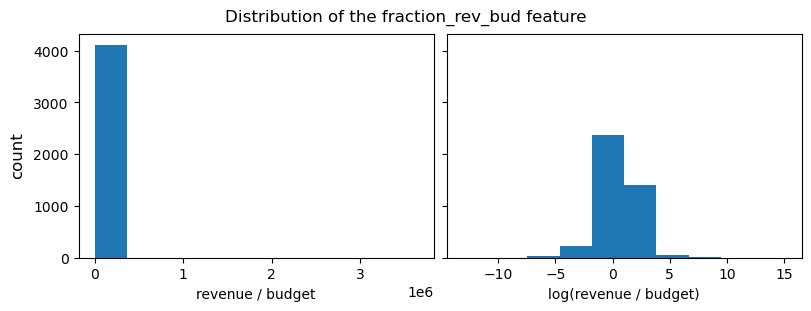

In [13]:
fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(8, 3), sharey=True)
ax[0].hist(data['fraction_rev_bud'])
ax[0].set_xlabel('revenue / budget')
ax[1].hist(np.log(data['fraction_rev_bud']))
ax[1].set_xlabel('log(revenue / budget)')
fig.supylabel('count')
plt.suptitle('Distribution of the fraction_rev_bud feature')
plt.show()

As the distribution of fraction_rev_bug is heavy-tailed, we took the log of it. Now, we have a more gaussian distribution. 

In [14]:
data['log_fraction_rev_bud'] = np.log(data['fraction_rev_bud'])
data = data.drop(columns = ['fraction_rev_bud'])

Then, we decided to incoporate some information about the actors of the movies :

In [15]:
# Not display the warnings, even if we used .loc the warnings are still there
pd.options.mode.chained_assignment = None

def add_actor_mean_age(x) :
    tmp = df_character[df_character['Freebase movie ID'] == x]
    return tmp['Actor age at movie release'].mean()
    
def add_actor_mean_height(x) :
    tmp = df_character[df_character['Freebase movie ID'] == x]
    return tmp['Actor height (in meters)'].mean()

def add_actor_frac_men(x) : 
    tmp = df_character[df_character['Freebase movie ID'] == x]
    men = (tmp['Actor gender'] == 'M').sum()
    women = (tmp['Actor gender'] == 'F').sum()
    if (men + women) == 0 : 
        return float('NaN')
    return men / (men + women)
    

data['mean_age'] = data['Freebase movie ID'].apply(lambda x : add_actor_mean_age(x))
data['mean_height'] = data['Freebase movie ID'].apply(lambda x : add_actor_mean_height(x))
data['fraction_men'] = data['Freebase movie ID'].apply(lambda x : add_actor_frac_men(x))

In [16]:
data = data.dropna(subset=['mean_age', 'mean_height', 'fraction_men'])

We displayed the distribition of these three new features to see if some transformations are required :

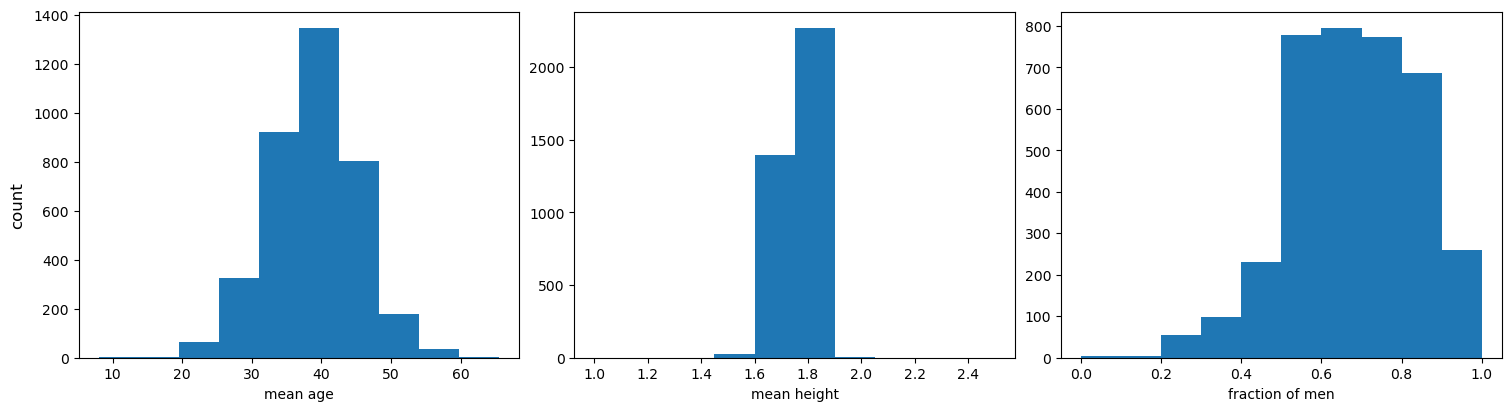

In [17]:
fig, ax = plt.subplots(1,3,constrained_layout=True, figsize=(15, 4))
ax[0].hist(data['mean_age'])
ax[0].set_xlabel('mean age')
ax[1].hist(data['mean_height'], range=[1,2.5])
ax[1].set_xlabel('mean height')
ax[2].hist(data['fraction_men'])
ax[2].set_xlabel('fraction of men')
fig.supylabel('count')
plt.show()

The new features do not require to be log transformed, as there are nearly gaussian-like.

Finally, we can remove the Freebase movie ID, as we map all the data that we wanted to the movies :

In [18]:
data = data.drop(columns=['Freebase movie ID'])

In [19]:
print(data.shape)
data.head(3)

(3688, 42)


,averageRating,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,KR,NZ,RU,US,log_revenue,log_budget,log_fraction_rev_bud,mean_age,mean_height,fraction_men
3690,7.7,1,0,0,0,0,1,0,0,0,...,0,0,0,1,19.108610,18.850228,0.258381,36.888889,1.752714,0.666667
3850,8.1,0,0,0,0,1,0,0,1,0,...,0,0,0,1,18.708726,17.125548,1.583178,37.600000,1.861667,0.705882
3853,7.2,0,0,0,0,0,0,0,1,0,...,0,0,0,1,19.704512,18.846162,0.858350,33.875000,1.752857,0.705882


### 2) Separation into groups according to budget and rating

We decided to separate the data into high, low budget and high, low rating categories. We took the 0.25 and 0.75 percentiles as cutoff.

In [20]:
data_HR_LB = data[np.logical_and(data['averageRating'] > data['averageRating'].quantile(0.75), data['log_budget'] < data['log_budget'].quantile(0.25))]
data_HR_HB = data[np.logical_and(data['averageRating'] > data['averageRating'].quantile(0.75), data['log_budget'] > data['log_budget'].quantile(0.75))]
data_LR_LB = data[np.logical_and(data['averageRating'] < data['averageRating'].quantile(0.25), data['log_budget'] < data['log_budget'].quantile(0.25))]
data_LR_HB = data[np.logical_and(data['averageRating'] < data['averageRating'].quantile(0.25), data['log_budget'] > data['log_budget'].quantile(0.75))]

print(data_HR_LB.shape)
print(data_HR_HB.shape)
print(data_LR_LB.shape)
print(data_LR_HB.shape)

(268, 42)
(206, 42)
(193, 42)
(214, 42)


We can interestingly see that there are more movies that have a high average rating and a low budget compare to the other categories. We have to do more analyses to conclude even if we took the same cutoff for all the categories.

First, we can inveatigate the genres of these categories (columns 1 to 20) :

In [21]:
data_HR_LB_genres = data_HR_LB.iloc[:,1:21]
data_HR_HB_genres = data_HR_HB.iloc[:,1:21]
data_LR_HB_genres = data_LR_HB.iloc[:,1:21]
data_LR_LB_genres = data_LR_LB.iloc[:,1:21]

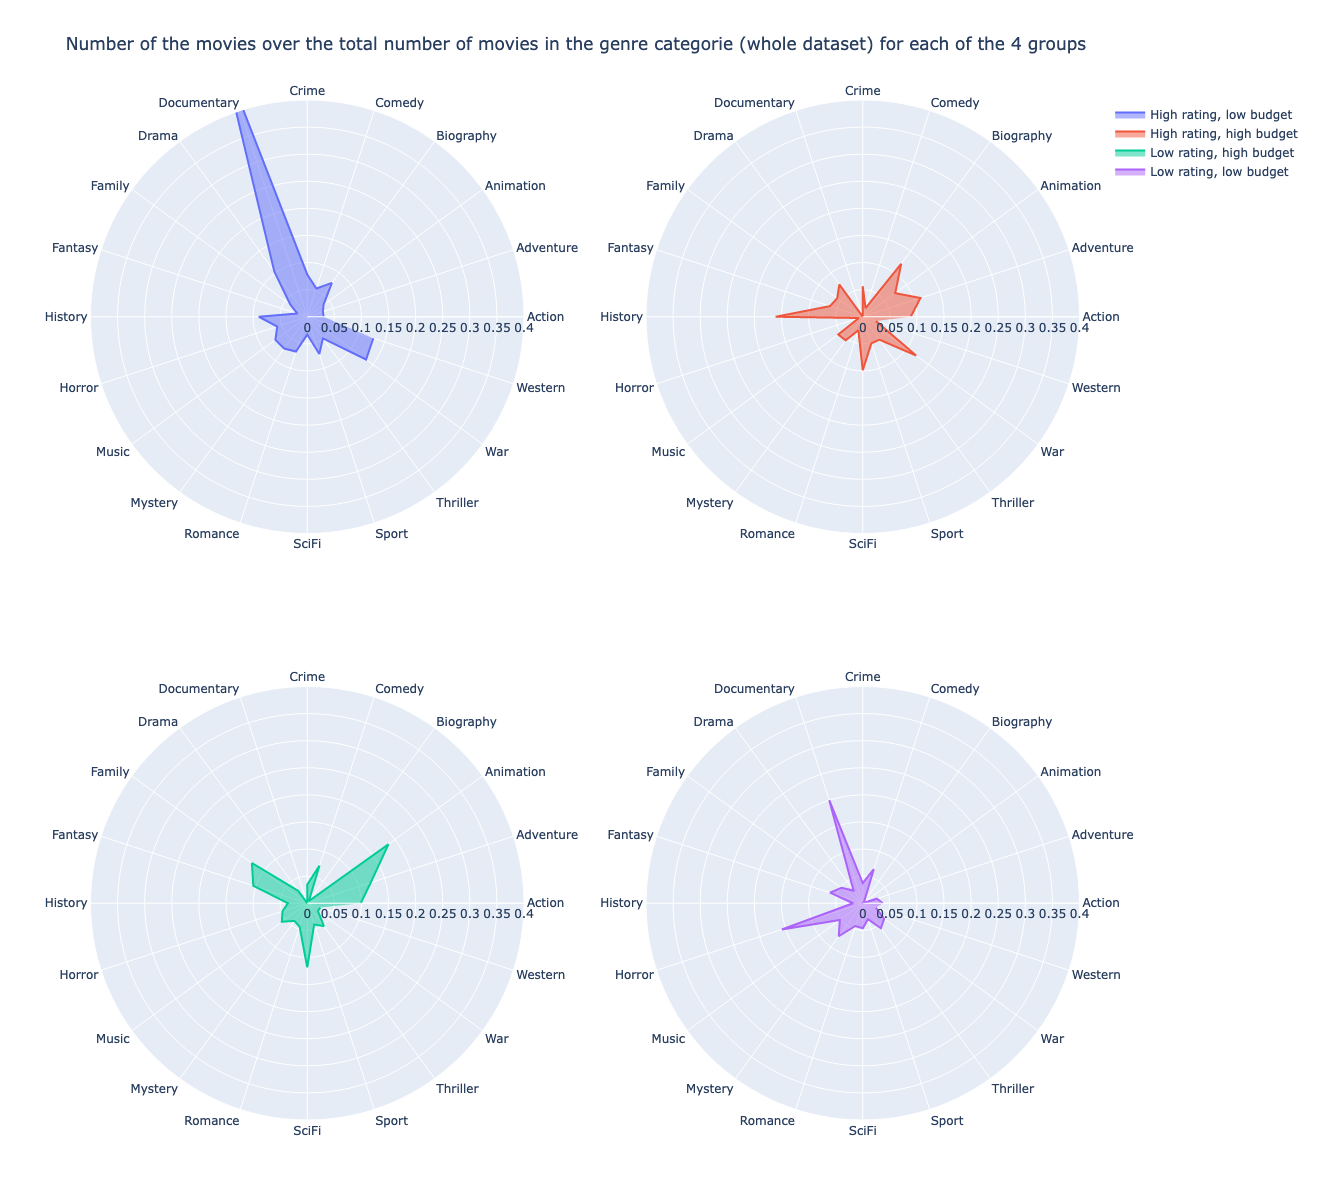

In [22]:
categories = data_HR_LB_genres.columns.values

fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2)

# Total count of the genres to normalize the count of the 4 groups 
total_count = data.iloc[:,1:21].sum().values

fig.append_trace(go.Scatterpolar(r=data_HR_LB_genres.sum().values/total_count, theta=categories, fill='toself', name='High rating, low budget'), row=1, col=1)
fig.append_trace(go.Scatterpolar(r=data_HR_HB_genres.sum().values/total_count, theta=categories, fill='toself', name='High rating, high budget'), row=1, col=2)
fig.append_trace(go.Scatterpolar(r=data_LR_HB_genres.sum().values/total_count, theta=categories, fill='toself', name='Low rating, high budget'), row=2, col=1)
fig.append_trace(go.Scatterpolar(r=data_LR_LB_genres.sum().values/total_count, theta=categories, fill='toself', name='Low rating, low budget'), row=2, col=2)
            
fig.update_polars(radialaxis=dict(range=[0, 0.4]))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
    width=1300,
    height=1200,
  showlegend=True,
    title_text = 'Number of the movies over the total number of movies in the genre categorie (whole dataset) for each of the 4 groups'
)

fig.show("jupyterlab")

The same plot but with superposition of all categories :

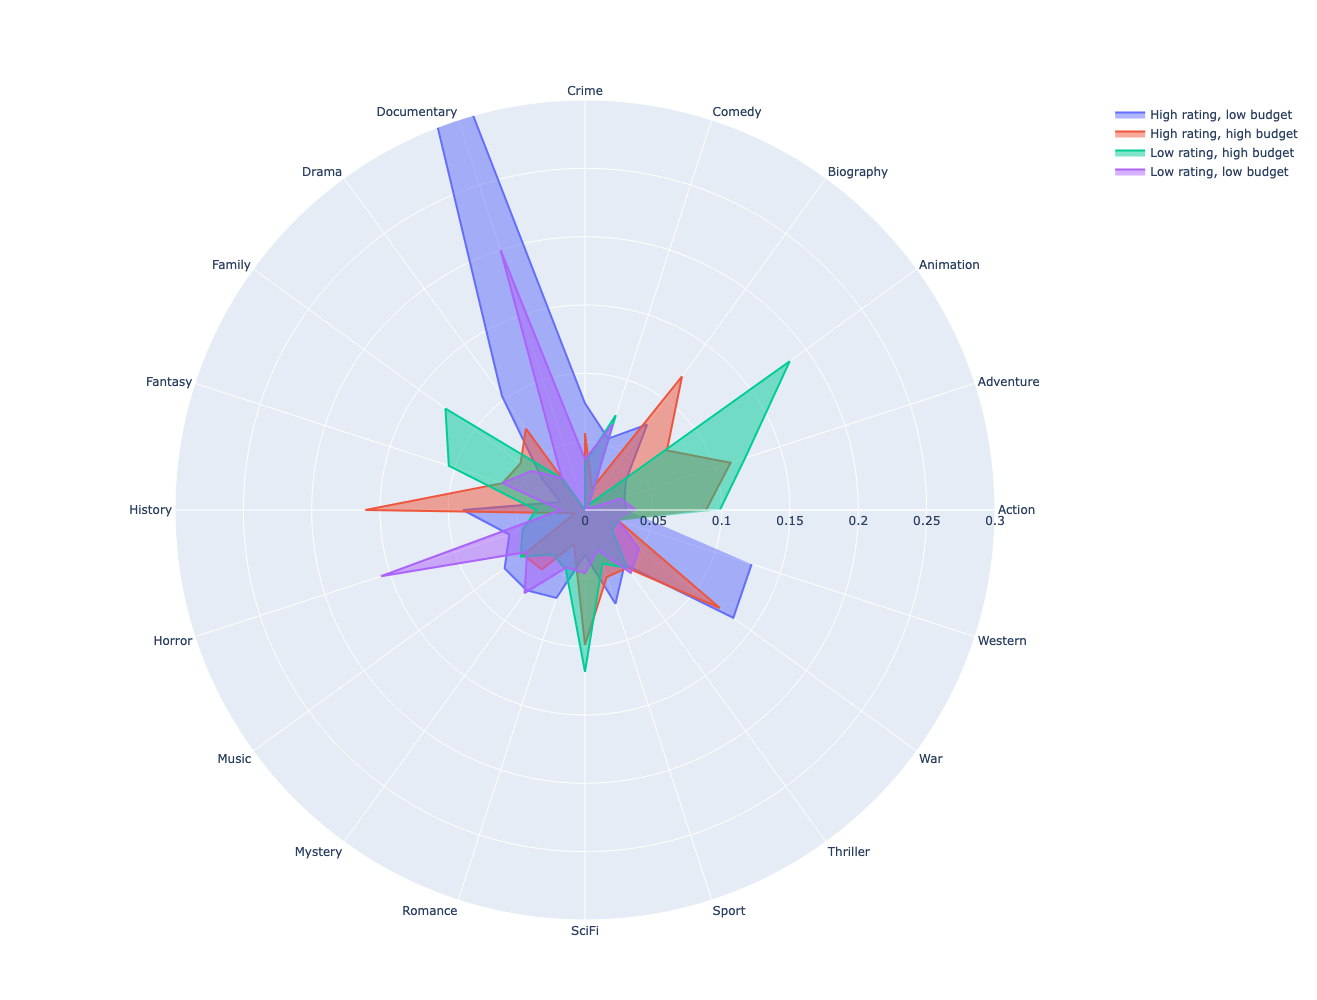

In [23]:
categories = data_HR_LB_genres.columns.values

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=data_HR_LB_genres.sum().values/total_count,
      theta=categories,
      fill='toself',
      name='High rating, low budget'
))
fig.add_trace(go.Scatterpolar(
      r=data_HR_HB_genres.sum().values/total_count,
      theta=categories,
      fill='toself',
      name='High rating, high budget'
))

fig.add_trace(go.Scatterpolar(
      r=data_LR_HB_genres.sum().values/total_count,
      theta=categories,
      fill='toself',
      name='Low rating, high budget'
))

fig.add_trace(go.Scatterpolar(
      r=data_LR_LB_genres.sum().values/total_count,
      theta=categories,
      fill='toself',
      name='Low rating, low budget'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 0.3]
    )),
    width=1000,
    height=1000,
  showlegend=True
)

fig.show('jupyterlab')

The fraction represented in these graphics are over the total number of movies of a particular genre in the whole dataset. It is why the fraction are small, because the 4 groups do not contain all the data. 

We can see that for :
* high rating - low budget categorie there are more documentary, western, war movies.
* high rating - high budget categorie there are more biography, history movies. There also several adventure, sci-fi and war movies, but less than the other categories
* low rating - high budget categorie there are more animation, scifi, fantansy, family and action movies.
* low rating - low budget categorie there are more horror. There are also several documentaries, but less than the other categories

Let's do some statistical tests of the data that is high rating - low budget vs the all the rest of the data on the sepcific genres that came out. We used independent t-test as there are not the same amount of movies in the 4 categories of rating and budget movies.

In [24]:
data_vs = data[np.logical_and(data['averageRating'] < data['averageRating'].quantile(0.75), data['log_budget'] > data['log_budget'].quantile(0.25))]
#data_vs = pd.concat((data_HR_HB_genres, data_LR_LB_genres, data_LR_HB_genres), axis=0)
genres_HR_LB = ['Documentary', 'Western', 'War'] 

for g in genres_HR_LB : 
    print(g)
    print('High rating - low budget vs the rest pval : {}'.format(scipy.stats.ttest_ind(data_HR_LB_genres[g], data_vs[g], alternative='greater').pvalue))
    print('\n')

Documentary
High rating - low budget vs the rest pval : 2.2633630300521388e-10


Western
High rating - low budget vs the rest pval : 0.09003443739148989


War
High rating - low budget vs the rest pval : 0.0012835763999404053




As we did 3 comparisons, we have to correct the level of signifance : 0.05 / 3 = 0.01667
The documentary and war movies are significantly greater in the low budget, high rating movies. For Western, we did not reach the level of significance.

Then, we can observe the production countries in the same manner (columns 21 to 35) :

In [25]:
data_HR_LB_countries = data_HR_LB.iloc[:,21:36]
data_HR_HB_countries = data_HR_HB.iloc[:,21:36]
data_LR_HB_countries = data_LR_HB.iloc[:,21:36]
data_LR_LB_countries = data_LR_LB.iloc[:,21:36]

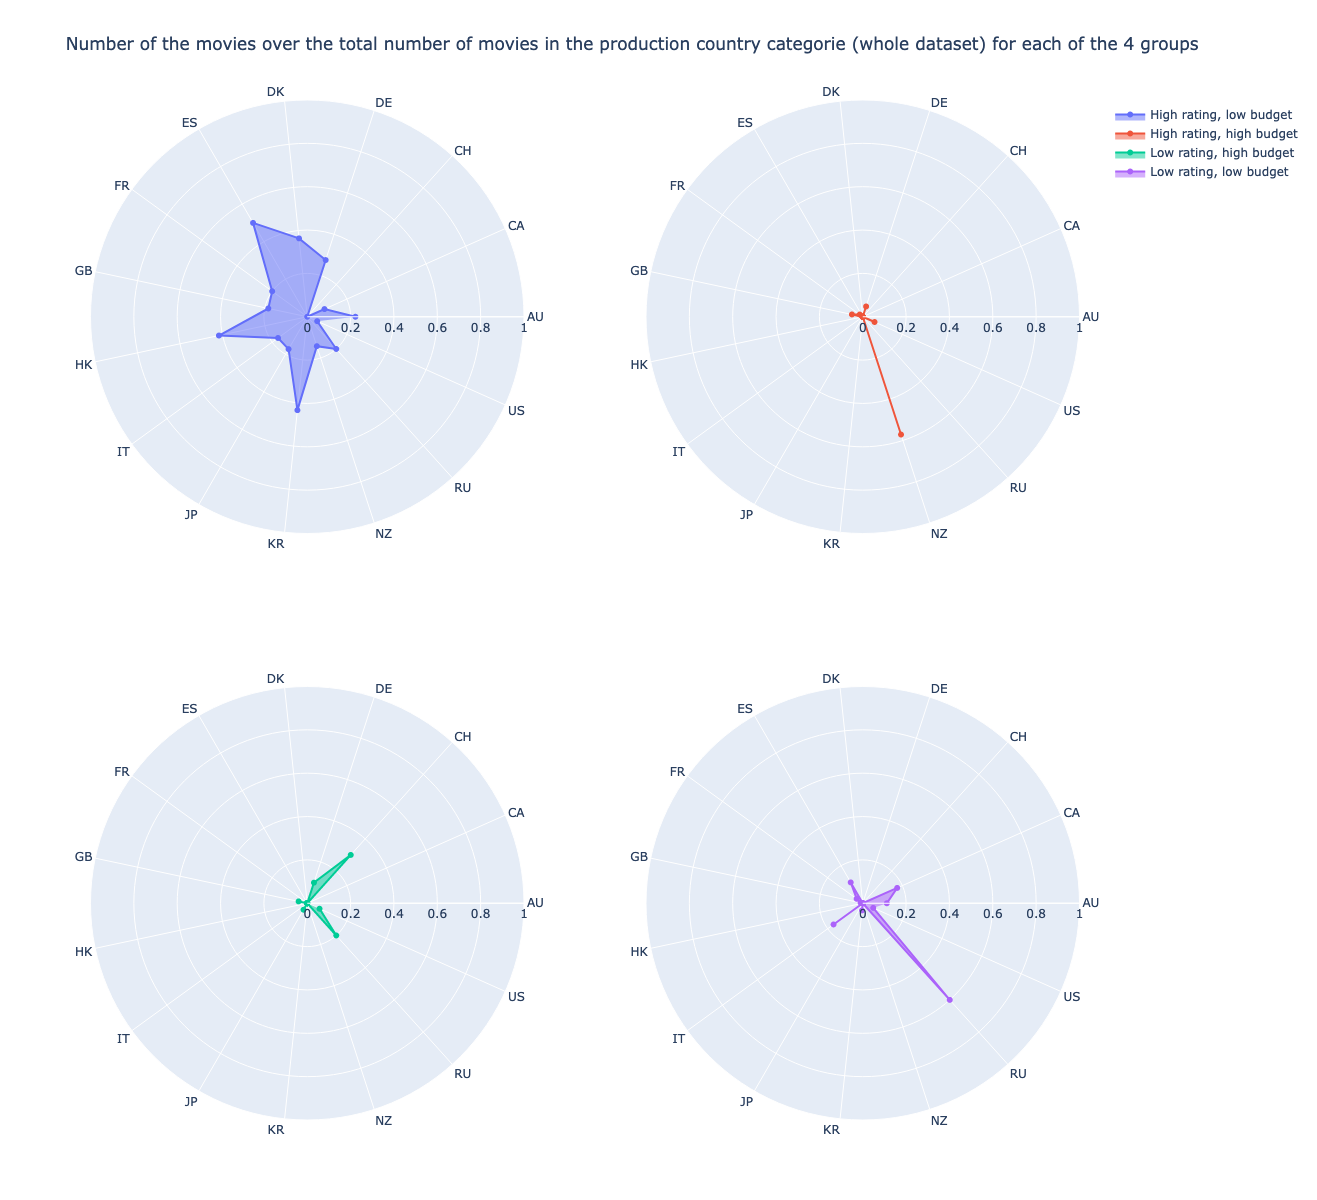

In [26]:
categories = data_HR_LB_countries.columns.values

fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2)

# Total count of the countries to normalize the count of the 4 groups 
total_count = data.iloc[:,21:36].sum().values

fig.append_trace(go.Scatterpolar(r=data_HR_LB_countries.sum().values/total_count, theta=categories, fill='toself', name='High rating, low budget'), row=1, col=1)
fig.append_trace(go.Scatterpolar(r=data_HR_HB_countries.sum().values/total_count, theta=categories, fill='toself', name='High rating, high budget'), row=1, col=2)
fig.append_trace(go.Scatterpolar(r=data_LR_HB_countries.sum().values/total_count, theta=categories, fill='toself', name='Low rating, high budget'), row=2, col=1)
fig.append_trace(go.Scatterpolar(r=data_LR_LB_countries.sum().values/total_count, theta=categories, fill='toself', name='Low rating, low budget'), row=2, col=2)
            
fig.update_polars(radialaxis=dict(range=[0, 1]))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
    width=1300,
    height=1200,
  showlegend=True,
    title_text = 'Number of the movies over the total number of movies in the production country categorie (whole dataset) for each of the 4 groups'
)

fig.show('jupyterlab')

The fraction represented in these graphics are over the total number of movies of a particular production country in the whole dataset. It is why the fraction are small, because the 4 groups do not contain all the data. 

We can see that for :
* high rating - low budget categorie there are more movies from DE, DK, ES, HK, KR than in the other categories, and the fraction around 0.5 so, it means nearly the majority of movies of the categorie. There are also many FR, GB and JP movies in this categorie.
* high rating - high budget categorie there are more from NZ.
* low rating - high budget categorie there are more from CH.
* low rating - low budget categorie there are more from RU.

It is interesting to see that in none of the categories the major production country (USA) has no peak. Indeed, USA produced the majority of the movies in this dataset. So, it means that USA produced movie that have an average budget or rating. It is more non usual production countries that appear in the categories of low/high rating and budget. We can see that DE, DK, ES, HK, KR has a good potential to produce cheap and good movies.

Let's do some statistical tests of the data that is high rating - low budget vs the all the rest of the data on the sepcific countries that came out :

In [27]:
data_vs = data[np.logical_and(data['averageRating'] < data['averageRating'].quantile(0.75), data['log_budget'] > data['log_budget'].quantile(0.25))]
# data_vs = pd.concat((data_HR_HB_countries, data_LR_LB_countries, data_LR_HB_countries), axis=0)
countries_HR_LB = ['DE', 'DK', 'ES', 'HK', 'KR', 'JP', 'FR', 'GB'] 

for c in countries_HR_LB : 
    print(c)
    print('High rating - low budget vs the rest pval : {}'.format(scipy.stats.ttest_ind(data_HR_LB_countries[c], data_vs[c], alternative='greater').pvalue))
    print('\n')

DE
High rating - low budget vs the rest pval : 1.405575628872474e-07


DK
High rating - low budget vs the rest pval : 7.259034679299697e-07


ES
High rating - low budget vs the rest pval : 1.8531023803783106e-12


HK
High rating - low budget vs the rest pval : 1.6030756768749175e-05


KR
High rating - low budget vs the rest pval : 1.261401292437605e-20


JP
High rating - low budget vs the rest pval : 0.006443594097054148


FR
High rating - low budget vs the rest pval : 1.2119868543804258e-09


GB
High rating - low budget vs the rest pval : 4.444491707357924e-07




As we did 8 comparisons, we have to correct the level of signifance : 0.05 / 8 = 0.00625
All the tested countries except JP reached the level of significance. So, there are more DE, DK, ES, HK, KR, FR, GB movies in the high rating - low budget categorie compared to the others.

Then, we can also observe the actor attributes in the same manner (columns 39 to 41) :

In [28]:
data_HR_LB_actor = data_HR_LB.iloc[:,39:42]
data_HR_HB_actor = data_HR_HB.iloc[:,39:42]
data_LR_HB_actor = data_LR_HB.iloc[:,39:42]
data_LR_LB_actor = data_LR_LB.iloc[:,39:42]
all_data_except_HR_LB_actor = data[np.logical_and(data['averageRating'] < data['averageRating'].quantile(0.75), \
                                                  data['log_budget'] > data['log_budget'].quantile(0.25))].iloc[:,39:42]
data_actor = [data_HR_LB_actor, data_HR_HB_actor, data_LR_HB_actor, data_LR_LB_actor, all_data_except_HR_LB_actor]
params = ['High rating, low budget', 'High rating, high budget', 'Low rating, high budget', 'Low rating, low budget', \
         'All data except high rating, low budget']
actors_params = ['mean_age', 'mean_height', 'fraction_men']

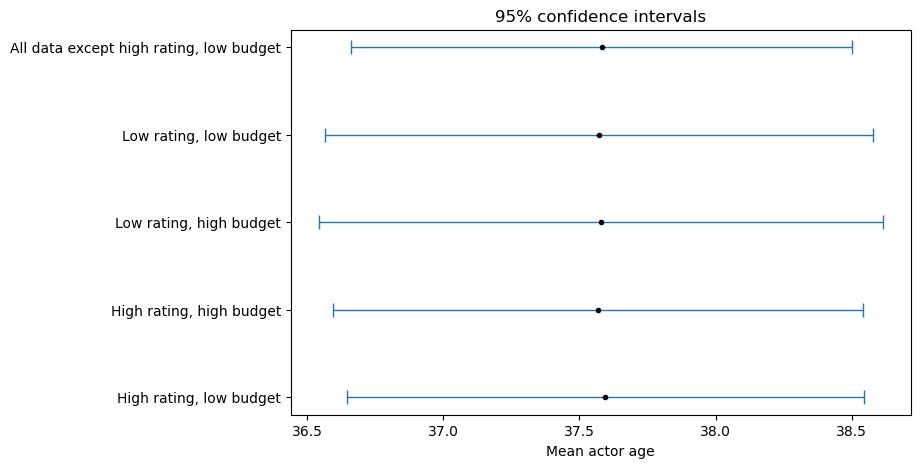

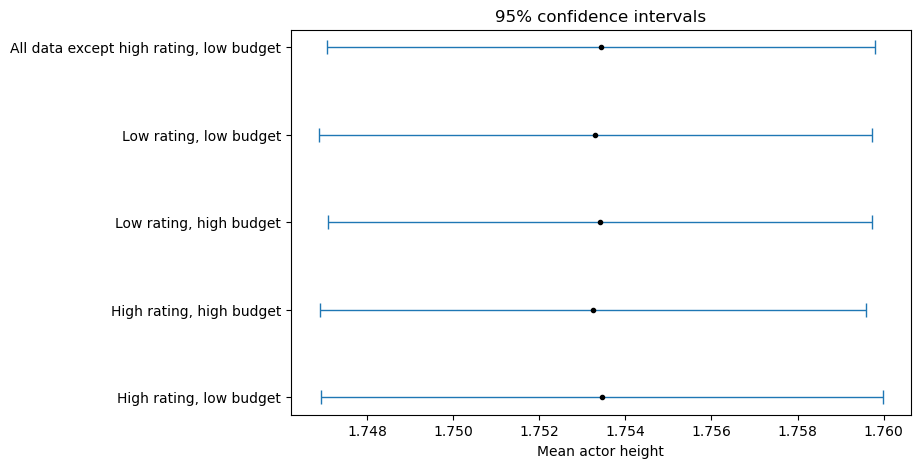

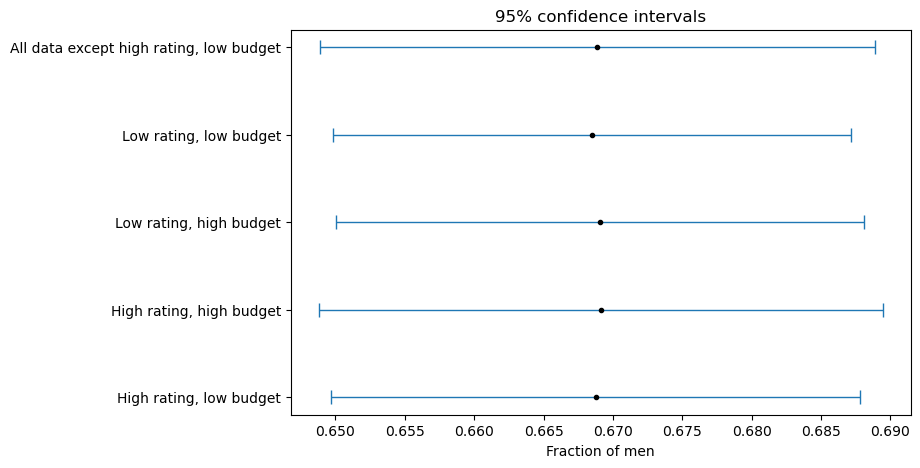

In [29]:
CIs_age = []
CIs_height = []
CIs_men = []

for d in data_actor :
    CIs_age.append(bootstrap(data_HR_LB_actor[actors_params[0]], 1000))
    CIs_height.append(bootstrap(data_HR_LB_actor[actors_params[1]], 1000))
    CIs_men.append(bootstrap(data_HR_LB_actor[actors_params[2]], 1000))

plot_CIs(CIs_age, params=params, xlabel='Mean actor age')
plot_CIs(CIs_height, params=params, xlabel='Mean actor height')
plot_CIs(CIs_men, params=params, xlabel='Fraction of men')

Here, the 'mean_age' column represents the mean age of actor per movie. We did the same for the 'mean height'. We also computed the fraction of men actors per movies. We decided to compute a 95% interval for these 3 features in each of the 4 datasets that we created by separation into high/low bugdet and rating and in the all the data except the high rating, low budget movies. We can see that no significant differences between these categories for none of the 3 features is shown.

As we saw no differences, maybe with the separation into old and recent movies, we can have something interesting. We choose the year 2000 as cutoff date as in the genre analysis :

In [30]:
def add_date(x) :
    return df_movie.loc[x]['Movie release date']

data_HR_LB['date'] = data_HR_LB.index.map(lambda x : add_date(x)).values

data_vs = data[np.logical_and(data['averageRating'] < data['averageRating'].quantile(0.75), data['log_budget'] > data['log_budget'].quantile(0.25))]
data_vs['date'] = data_vs.index.map(lambda x : add_date(x)).values

# split data in two periods: from 1959 to 2000 and from 2000 to 2021.
old_movies_HR_LB = data_HR_LB[data_HR_LB.date < 2000]
recent_movies_HR_LB = data_HR_LB[data_HR_LB.date >= 2000]
old_movie_data_vs = data_vs[data_vs.date < 2000]
recent_movie_data_vs = data_vs[data_vs.date > 2000]

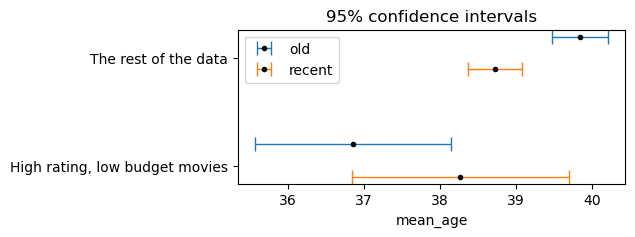

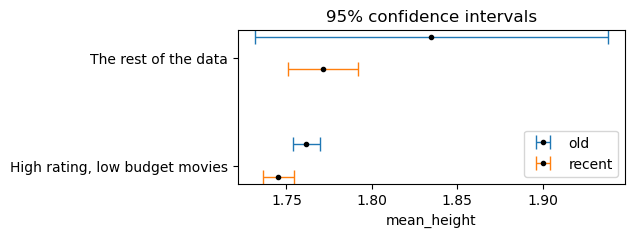

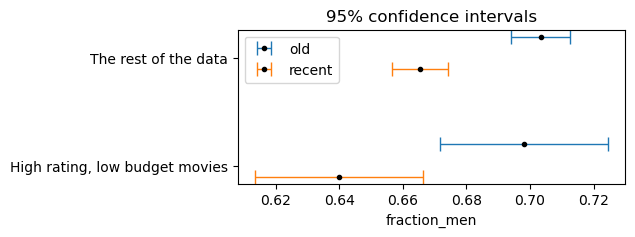

In [31]:
CIs_old = []
CIs_recent = []
CIs_old_vs = []
CIs_recent_vs = []

for p in actors_params :
    CIs_old.append(bootstrap(old_movies_HR_LB[p], 1000))
    CIs_recent.append(bootstrap(recent_movies_HR_LB[p], 1000))
    CIs_old_vs.append(bootstrap(old_movie_data_vs[p], 1000))
    CIs_recent_vs.append(bootstrap(recent_movie_data_vs[p], 1000))

for i in range(3) :
    #plot_double_CIs(np.expand_dims(CIs_old[i], 0), np.expand_dims(CIs_recent[i], 0), params=np.expand_dims(actors_params[i], 0), xlabel=None, figsize=(5,2))
    plot_double_CIs([CIs_old[i], CIs_old_vs[i]], [CIs_recent[i], CIs_recent_vs[i]], params=['High rating, low budget movies', 'The rest of the data'], xlabel=actors_params[i], figsize=(5,2))

Comparison inside the high rating, low budget (HR-LB) movies :
* There are significantly more female actors in the new movies (fraction of men is lower). 
* It seems to have a tendency in the new movies to have older and shorter actors. 

Comparison inside the rest of the movies :
* The actors are now significantly younger than before
* There are significantly more female actors in the new movies (fraction of men is lower). 

Comparison between HR-LB movies and the rest of the data :
* Before 2000, actors of HR-LB movies were significantly younger
* For the rest, there are no significant difference

### 3) Separation into groups according to budget and revenue

One other way to measure the success of a movie is the revenue. Here, we decided to take into account the revenue / budget as measure of the sucess instead of the rating. We decided to select low budget (less than 0.25 quantile of the budget) and good (more than 0.75 quantile of the log_fraction_rev_bud) movies

In [32]:
# data high fraction (revenue / budget), low budget
print('The 0.75 quantile of the log_fraction_rev_bud is {}, which means fraction_rev_bud of {} '.format(data['log_fraction_rev_bud'].quantile(0.75), \
    np.exp(data['log_fraction_rev_bud'].quantile(0.75))))
data_HF_LB = data[np.logical_and(data['log_fraction_rev_bud'] > data['log_fraction_rev_bud'].quantile(0.75), data['log_budget'] < data['log_budget'].quantile(0.25))]
data_HF_LB.shape

The 0.75 quantile of the log_fraction_rev_bud is 1.2933167088501418, which means fraction_rev_bud of 3.6448554545209126 


(351, 42)

There are 351 movies in this subset, let's compare it with the high rating, low budget subset to see if they contain the same movies :

In [33]:
data_HF_LB.index.difference(other=data_HR_LB.index, sort=None)

Int64Index([  9833,   9899,   9987,  10240,  10245,  10374,  10406,  10511,
             10578,  10592,
            ...
            100323, 103209, 104133, 105722, 107982, 108611, 108964, 109951,
            110933, 111102],
           dtype='int64', length=208)

There are 208 movies that are in the data_HF_LB and not in data_HR_LB. They have 351-208 = 143 movies in common.

### 4) PCA

Before doing PCA, we have to standardize some features to have all the features in the same range of values :

In [34]:
def standardize(data):
    return (data - np.nanmean(data)) / np.std(data)

data['log_budget'] = standardize(data['log_budget'])
data['log_revenue'] = standardize(data['log_revenue'])
data['averageRating'] = standardize(data['averageRating'])
data['mean_age'] = standardize(data['mean_age'])
data['mean_height'] = standardize(data['mean_height'])
data['fraction_men'] = standardize(data['fraction_men'])

Now, we can perform dimensionality reduction :

In [35]:
pca = decomposition.PCA(n_components=10)
pca.fit(data.T)

PCA(n_components=10)

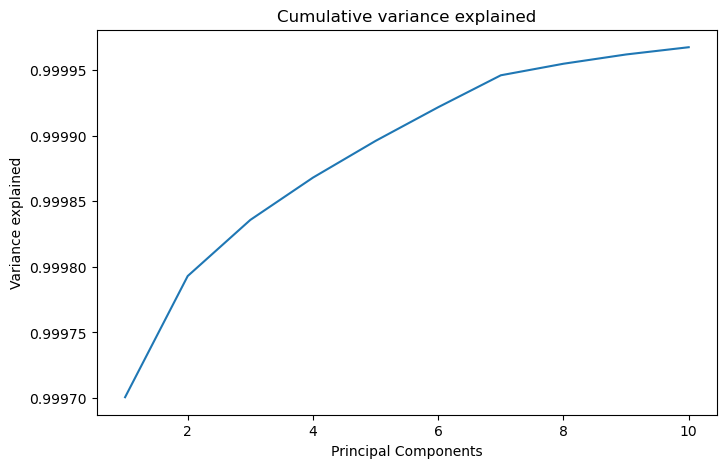

In [36]:
# compute cumulative explained variance
plt.figure(figsize=(8,5))
plt.title('Cumulative variance explained')
sns.lineplot(x = np.arange(1,11,1), y = np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal Components')
plt.ylabel('Variance explained')
plt.show()

With 10 components, we can capture 90% of the variance in the data, but we already capture 80% with 8 components.
Let's observe some 2D principal components plots.

In [37]:
def plot_components(comp, color = None, alpha = None):
    if color is None : color = 'darkgreen'
    fig, axs = plt.subplots(ncols=3, figsize=(10,5), layout="constrained")
    axs[0].scatter(comp[0,:], comp[1,:], c = color, alpha = alpha)
    axs[0].set_xlabel('PC1')
    axs[0].set_ylabel('PC2')
    axs[1].scatter(comp[0,:], comp[2,:], c = color, alpha = alpha)
    axs[1].set_xlabel('PC1')
    axs[1].set_ylabel('PC3')
    axs[2].scatter(comp[1,:], comp[2,:], c = color, alpha = alpha)
    axs[2].set_xlabel('PC2')
    axs[2].set_ylabel('PC3')
    plt.suptitle('Principal components subplots')
    plt.show()

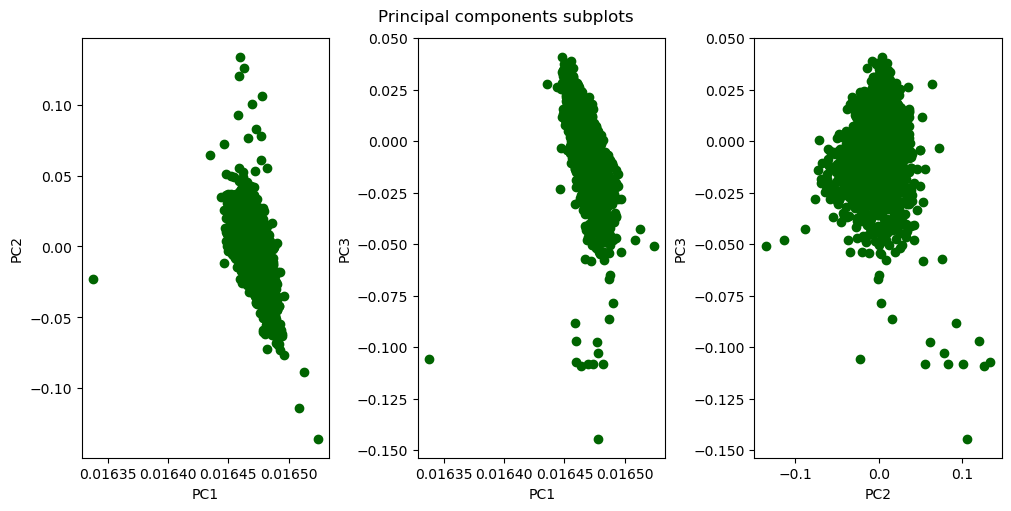

In [38]:
plot_components(pca.components_)

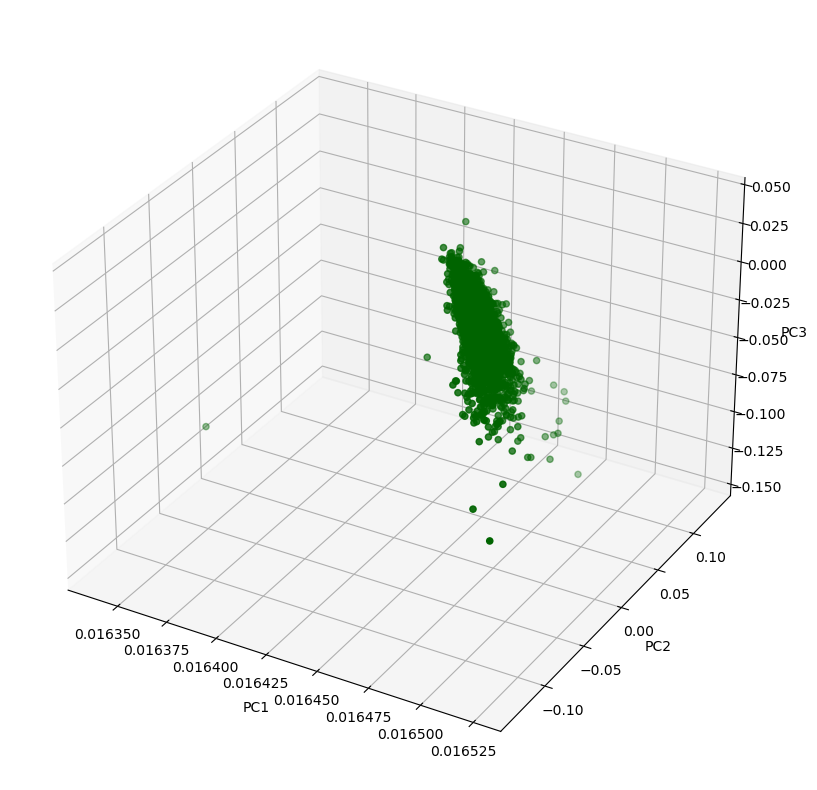

In [39]:
fig = plt.figure(figsize =(10,10))
ax = plt.axes(projection='3d')

ax.scatter(pca.components_[0,:], pca.components_[1,:], pca.components_[2,:], color = 'darkgreen')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()